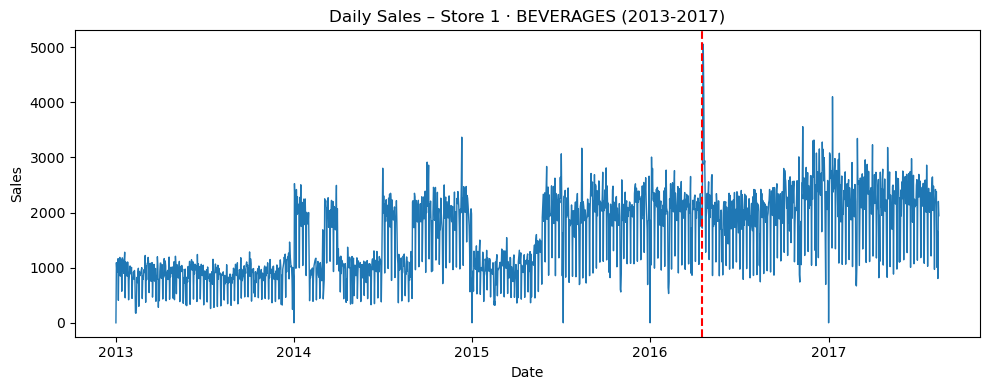

  0%|▏                                                                              | 3/1782 [00:15<2:32:59,  5.16s/it]

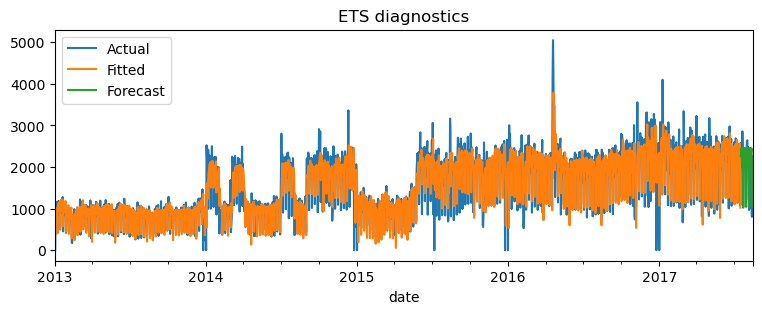

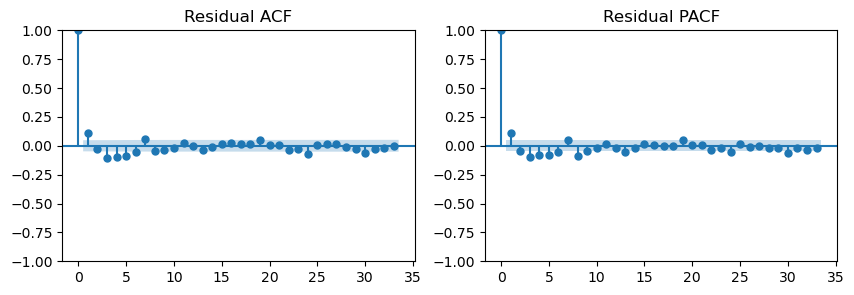

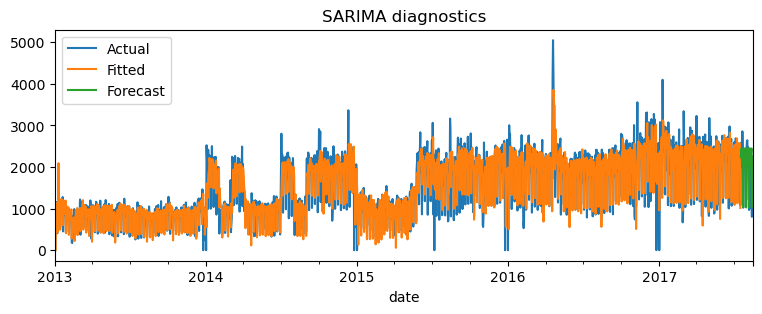

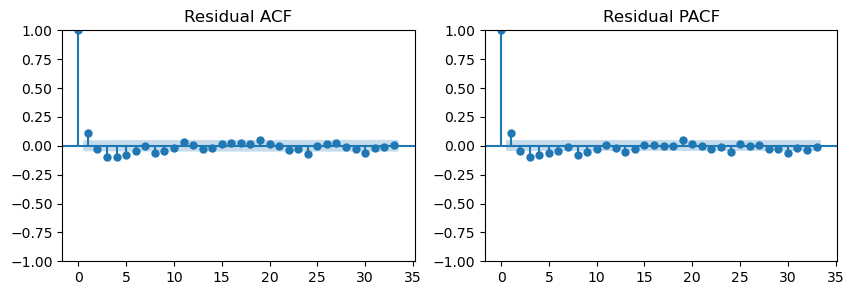

 19%|██████████████▊                                                              | 344/1782 [23:38<1:40:15,  4.18s/it]

In [ ]:
#=======================================================================
# Store Sales - Time Series Forecasting
# Kaggle competition: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview
# DSS8555 Assignment 8
# April 27, 2025
# Min Jeong Lim
#=======================================================================

# install 1 time
!pip install --quiet statsmodels tqdm pandas numpy

import gc, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

# data load
PATH = "Store Sales"                                  
train = pd.read_csv(f"{PATH}/train.csv", parse_dates=['date'])
test  = pd.read_csv(f"{PATH}/test.csv",  parse_dates=['date'])
H, VAL = 16, 30                                       # horizon, hold-out

# data explore plot
sample = (train.query("store_nbr==1 and family=='BEVERAGES'")
                .sort_values('date'))

plt.figure(figsize=(10,4))
plt.plot(sample['date'], sample['sales'], lw=1)
plt.axvline(pd.Timestamp("2016-04-16"), ls="--", color="red")  # M7.8 earthquake
plt.title("Daily Sales – Store 1 · BEVERAGES (2013-2017)")
plt.ylabel("Sales"); plt.xlabel("Date")
plt.tight_layout()
plt.savefig("Figure1_Store1_Beverages.png", dpi=300)   # saved for the paper
plt.show()


# helpers
def my_metrics(y, yhat):
    mse  = mean_squared_error(y, yhat); rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y, yhat)
    mape = np.mean(np.abs((y - yhat)/y.replace({0:np.nan})))
    me   = np.mean(y - yhat)
    return mse, rmse, mae, mape, me

metric_names = ["MSE","RMSE","MAE","MAPE","ME"]

def build_ets(series, horizon):
    """Additive Holt-Winters weekly season (ETS)."""
    mod = ExponentialSmoothing(series,
                               trend="add",
                               seasonal="add",
                               seasonal_periods=7,
                               damped_trend=True).fit(optimized=True, use_brute=True)
    return mod, mod.forecast(horizon)

def build_sarima(series, horizon):
    """Fixed SARIMA (0,1,1)(1,1,1)[7]; if it fails → random walk."""
    try:
        mod = SARIMAX(series,
                      order=(0,1,1),
                      seasonal_order=(1,1,1,7),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(disp=False)
    except Exception as e:
        print("  ↪ SARIMA fell back to RW: ", e)
        mod = SARIMAX(series, order=(0,1,0)).fit(disp=False)
    return mod, mod.forecast(horizon)

def diag_plot(series, mod, horizon, title):
    fitted = mod.fittedvalues
    fc     = mod.forecast(horizon)
    ax = series.plot(label="Actual", figsize=(9,3)); fitted.plot(ax=ax, label="Fitted")
    fc.plot(ax=ax, label="Forecast"); ax.set_title(title); ax.legend(); plt.show()
    resid = series - fitted
    fig,(a,b)=plt.subplots(1,2, figsize=(10,3))
    plot_acf(resid.dropna(), ax=a);  a.set_title("Residual ACF")
    plot_pacf(resid.dropna(), ax=b); b.set_title("Residual PACF"); plt.show()

# main loop
sub_ets = np.zeros(len(test)); sub_sarima = np.zeros(len(test))
mets_ets, mets_sar = [], []

g = train.groupby(['store_nbr','family'])
for (store,fam), df in tqdm(g, total=g.ngroups):
    y = df.sort_values('date').set_index('date')['sales'].asfreq('D').fillna(0)
    y_tr, y_val = y[:-VAL], y[-VAL:]

    # ETS
    ets_mod, ets_val_fc = build_ets(y_tr, VAL)
    mets_ets.append(my_metrics(y_val, ets_val_fc))

    # SARIMA (fixed)
    sa_mod, sa_val_fc = build_sarima(y_tr, VAL)
    mets_sar.append(my_metrics(y_val, sa_val_fc))

    # refit on full history
    _, ets_fc = build_ets(y, H)
    _, sa_fc  = build_sarima(y, H)

    mask = (test.store_nbr==store) & (test.family==fam)
    sub_ets[mask]   = ets_fc.values
    sub_sarima[mask]= sa_fc.values

    if store==1 and fam=="BEVERAGES":      # one diagnostic example
        diag_plot(pd.concat([y_tr, y_val]), ets_mod, VAL, "ETS diagnostics")
        diag_plot(pd.concat([y_tr, y_val]), sa_mod,  VAL, "SARIMA diagnostics")

    del ets_mod, sa_mod; gc.collect()

# summary metric
df_e = pd.DataFrame(mets_ets,  columns=metric_names)
df_s = pd.DataFrame(mets_sar, columns=metric_names)
summary = pd.concat({"ETS_mean":df_e.mean(),
                     "SARIMA_mean":df_s.mean(),
                     "ETS_median":df_e.median(),
                     "SARIMA_median":df_s.median()}, axis=1)
print("\nHold-out metrics averaged over all series:"); print(summary.round(3))

# writing of 2 submission files
pd.DataFrame({"id":test.id, "sales":sub_ets.round(4)})   \
  .to_csv("submit_ETS.csv", index=False)
pd.DataFrame({"id":test.id, "sales":sub_sarima.round(4)})\
  .to_csv("submit_ARIMA.csv", index=False)
print("\n✔️  submission_ETS.csv  and  submission_ARIMA.csv created.")
print("Upload each separately for the two required Kaggle submissions.")
